<a href="https://colab.research.google.com/github/Victorlouisdg/simulators/blob/main/jax_implicit_cloth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install meshzoo

In [3]:
import numpy as np
import jax.numpy as jnp
import jax.scipy.sparse
from jax import grad, jit, vmap
from jax import jacfwd, jacrev
from jax.lax import cond, scan
from jax.ops import index, index_add, index_update
np.set_printoptions(precision=3, suppress=True)
import meshzoo
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
matplotlib.rc('animation', html='jshtml')
from functools import partial

## Getting the mesh
Baraff & Witkin simulate cloth as a 3D triangle mesh, but with a 2D rest state. 
This reflects the fact that clothes are made from pieces cut out of 2D sheets of fabric.

In [4]:
rest_positions_2D, triangles = meshzoo.rectangle_tri(
    (0.0, 0.0),
    (1.0, 1.0),
    n=5,
    variant="zigzag",  # or "up", "down", "center"
)

rest_positions_2D = jnp.array(rest_positions_2D)
amount_of_triangles = triangles.shape[0]

print("There are", amount_of_triangles, "triangles in the mesh.")
print("The first triangle contains vertices:", triangles[0])

There are 50 triangles in the mesh.
The first triangle contains vertices: [0 1 7]


## Initializing the 3D positions

In [5]:
amount_of_vertices = rest_positions_2D.shape[0]
positions_z = np.zeros(amount_of_vertices)

positions = jnp.column_stack([rest_positions_2D, positions_z]).flatten()
velocities = jnp.zeros_like(positions)

print("There are", amount_of_vertices, "vertices in the mesh.")
positions.shape

There are 36 vertices in the mesh.


(108,)

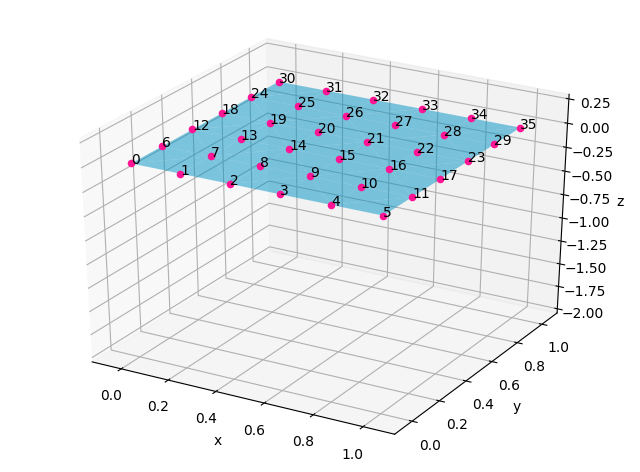

In [32]:
def plot_cloth(ax, positions, triangles):
    x = positions[0::3]
    y = positions[1::3]
    z = positions[2::3]

    # ax.clear()  # necessary for the animations later
    ax.plot_trisurf(x, y, z, triangles=triangles, color='deepskyblue', alpha=0.5)
    ax.scatter(x, y, z, c='deeppink', s=20, depthshade=False)
    for i, (xi, yi, zi) in enumerate(zip(x, y, z)):
        ax.text(xi, yi, zi, str(i), fontsize='medium', color='black', zorder=10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.set_zlim([-2, 0.25])

fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111, projection='3d')
plot_cloth(ax, positions, triangles)

## Defining the energy of a single triangle.

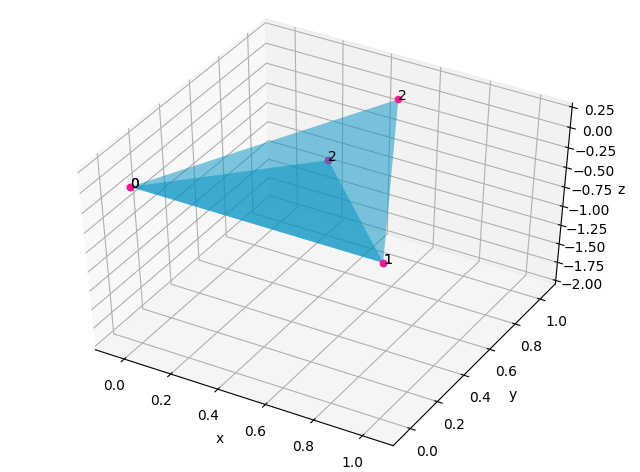

In [34]:
triangle = [0, 1, 2]
triangle_positions = jnp.array([0.0, 0.0, 0.0,
                                1.0, 0.0, 0.0,
                                0.5, 0.5, 0.0])

triangle_rest_positions_2D = jnp.array([[0.0, 0.0], [1.0, 0.0], [0.5, 0.5]])

fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(triangle_positions[6], triangle_positions[7],triangle_positions[8], c='deeppink', s=20, depthshade=False)

ax.view_init(azim=300, elev=45)
plot_cloth(ax, triangle_positions, [triangle])

triangle_positions_new = index_add(triangle_positions, 7, 0.5)
plot_cloth(ax, triangle_positions_new, [triangle])



In [86]:
import plotly.graph_objs as go
import plotly.io as pio

pio.templates.default = "plotly_white" # "simple_white"


x = positions[0::3]
y = positions[1::3]
z = positions[2::3]

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

'4.4.1'

In [97]:
def get_cloth_plot_data(positions, triangles):
    x = positions[0::3]
    y = positions[1::3]
    z = positions[2::3]

    i = [t[0] for t in triangles]
    j = [t[1] for t in triangles]
    k = [t[2] for t in triangles]

    data = [go.Scatter3d(
                x=x, y=y, z=z,
                mode='markers',
                marker=dict(size=5, color='deeppink')
        ), go.Mesh3d(
                x=x, y=y, z=z,
                i=i, j=j, k=k,
                color='deepskyblue'
        )]

    return data

def get_cloth_fig(positions, triangles):
    fig = go.Figure(data=get_cloth_plot_data(positions, triangles))
    fig.update_layout(scene = dict(
        xaxis=dict(range=[-0.1, 1.1], autorange=False),
        yaxis=dict(range=[-0.1, 1.1], autorange=False),
        zaxis=dict(range=[-2, 0.25], autorange=False),
    ))
    return fig

get_cloth_fig(positions, triangles).show()

In [98]:
def get_cloth_frames(history, triangles):
    frames = [go.Frame(data=get_cloth_plot_data(history[i], triangles)) for i in range(len(history))]
    return frames


def animate_cloth2(history, triangles):
    fig = get_cloth_fig(history[0], triangles)

    fig.update_layout(updatemenus=[dict(type="buttons",
                          buttons=[dict(label="Play",
                                        method="animate",
                                        args=[None, dict(frame=dict(redraw=True,fromcurrent=True, mode='immediate'))]
                                        )])])

    fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
    fig.update(frames=get_cloth_frames(history, triangles))
    fig.show()



history = []
for i in range(100):
    history.append(index_add(positions, index[2::3], -0.01 * i))

animate_cloth2(history, triangles)

In [8]:
|def deformation_gradient(vertex_positions, vertex_positions_uv):
    uv0, uv1, uv2 = vertex_positions_uv
    u0, v0 = uv0
    u1, v1 = uv1
    u2, v2 = uv2

    delta_u1 = u1 - u0
    delta_u2 = u2 - u0
    delta_v1 = v1 - v0
    delta_v2 = v2 - v0

    delta_u_matrix = jnp.array([(delta_u1, delta_u2),
                               (delta_v1, delta_v2)])
    
    inverted_delta_u_matrix = jnp.linalg.inv(delta_u_matrix)

    x0, x1, x2 = vertex_positions

    delta_x1 = x1 - x0
    delta_x2 = x2 - x0

    delta_x_matrix = jnp.column_stack((delta_x1, delta_x2))

    # Equation (9) in Baraff-Witkin.
    w_uv = delta_x_matrix @ inverted_delta_u_matrix
    
    wu, wv = jnp.hsplit(w_uv, 2)

    return wu, wv

In [9]:
def triangle_area(triangle_vertices):
    v0, v1, v2 = triangle_vertices
    return jnp.linalg.norm(jnp.cross(v1 - v0, v2 - v0)) / 2.0

In [10]:
def stretch_energy(positions, rest_positions, ku, kv):
    """
    Calculates the energy due to stretching of a single triangle.

    :param positions: The current 3D positions of the 3 vertices.
    :param rest_positions: The 2D rest positions of the 3 vertices.
    :param ku: The stretch stiffness along the first 2D dimension.
    :param kv: The stretch stiffness along the second 2D dimension.
    """
    wu, wv = deformation_gradient(positions, rest_positions)
    area_uv = triangle_area(rest_positions)

    Cu = jnp.linalg.norm(wu) - 1.0
    Cv = jnp.linalg.norm(wv) - 1.0

    Eu = 0.5 * area_uv * (Cu ** 2)
    Ev = 0.5 * area_uv * (Cv ** 2)

    E = ku * Eu + kv * Ev
    return E

In [11]:
def slice3(i):
    return slice(3*i, 3*i+3)

In [12]:
i, j, k = triangle

uv0, uv1, uv2 = triangle_rest_positions_2D[jnp.array([i, j, k])]

x0 = triangle_positions[slice3(i)]
x1 = triangle_positions[slice3(j)]
x2 = triangle_positions[slice3(k)]

stretch_energy((x0, x1, x2), (uv0, uv1, uv2), 200.0, 200.0)

DeviceArray(0., dtype=float32)

In [13]:
triangle_positions_new = index_add(triangle_positions, 7, 0.5)

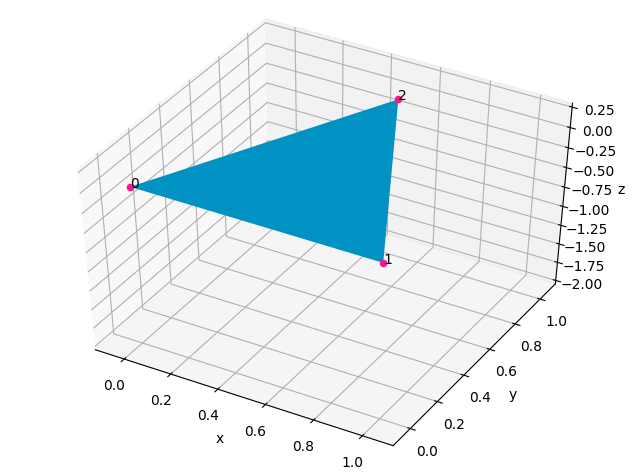

In [14]:
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(azim=300, elev=45)
plot_cloth(ax, triangle_positions_new, [triangle])